# Problem set 1 : Seeing in Color

## Part 1: Color Alignment

In [42]:
# This cell sets up inline image display functionaility
%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
# import packages we will need
import numpy as np
import cv2  # if you don't have it, you can install it in anaconda prompt: pip install opencv-python
import matplotlib.image as mpimg

import scipy
import scipy.ndimage
from imageio import imread, imsave

In [44]:
def plot_image(img, size, cmap=None):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

### Naive stacking
If we simply ignore the shifts, we get a distorted image of course:

Image height 370 x width 370


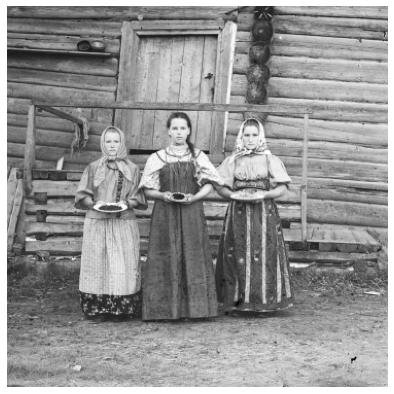

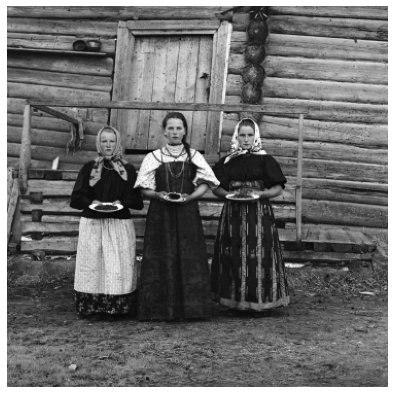

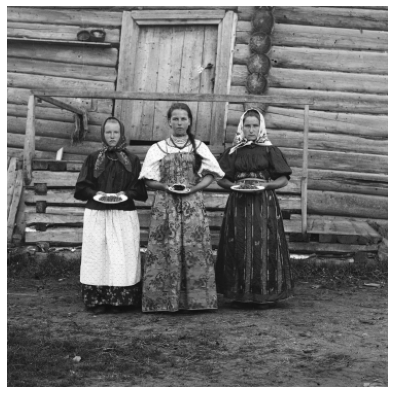

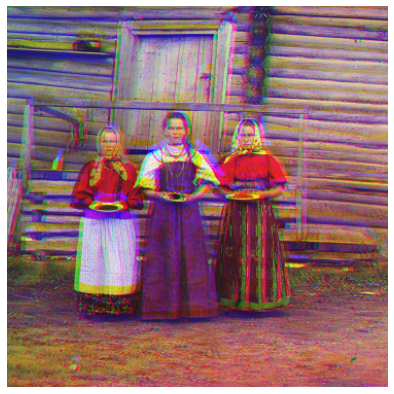

In [45]:
# A demo of naive stacking

red = np.array(imread('images/prokudin-girls-red.ppm', as_gray=True) / 255.0)
blue = np.array(imread('images/prokudin-girls-blue.ppm', as_gray=True) / 255.0)
green = np.array(imread('images/prokudin-girls-green.ppm', as_gray=True) / 255.0)

print('Image height %d x width %d'% (blue.shape[0],blue.shape[1]))

for layer in [red, green, blue]:
    plot_image(layer, (14, 7), 'gray')

# now try to just superimpose the three channels
color = np.stack((red, green, blue), axis=-1)
plot_image(color, (14, 7))

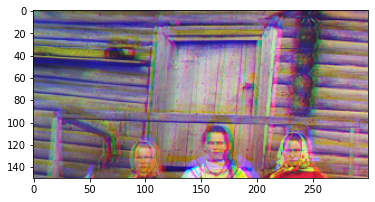

In [46]:
# note the image axis convention vs plot axis convention. Image origin (0, 0) sits at the top-left corner of the plot. 
# image shape [height, width, channel]. height comes first. 
plt.imshow(color[0:150, 0:300, :])  # a crop at the top-left corner
plt.show()

## Synthetic experiment
We will start by simulating the shifts by taking a color image obtained with modern color camera, inducing color channel misalignment by shifting the color channels. Then we can attempt to recover the original image by finding the shifts that minimize the SSD between the (un)shifted channels.

### Problem 1: Implement this by completing the code below.

In [47]:
# note that y-axis is dimention 0. x-axis is domension 1. 

def shift_image_y(input_image, dy):
    input_image = np.roll(input_image, dy, axis = 0)
    return input_image 

def shift_image_x(input_image, dx):
    input_image = np.roll(input_image, dx, axis = 1)
    return input_image


def apply_shift(input_image, dy, dx):
    return shift_image_y(
        shift_image_x(input_image, dx), 
        dy
    )

Now we can look at the original image; the image with shifted channels stacked naively; and the restored image where we invert the shifts using the optimal value found. This final image should match the original (other than near the borders, of course, where the shifting loses information) 

(207, 384, 3)


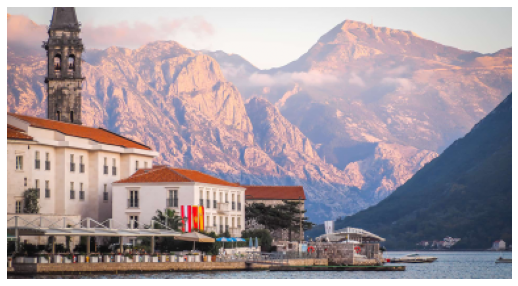

In [48]:
test_image = np.array(imread('images/test-image.png') / 255.0)
print(test_image.shape)
# show the original image
plot_image(test_image, (10, 5))

Real shift: R [y: 13, x: 0], B [y: -12, x: -7]


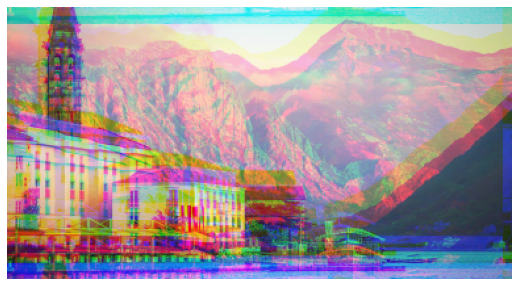

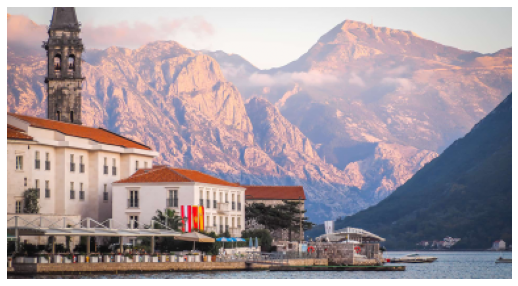

In [49]:
red_shift = np.random.randint(-15, 15, (2,));
red_channel = apply_shift(test_image[..., 0], *red_shift)

green_channel = test_image[..., 1]

blue_shift = np.random.randint(-15, 15, (2,));
blue_channel = apply_shift(test_image[..., 2], *blue_shift)

print('Real shift: R [y: %d, x: %d], B [y: %d, x: %d]' % (*red_shift, *blue_shift))

synth_image = np.stack((red_channel, green_channel, blue_channel), axis=-1)

# show the naive stacking result (should be distorted)
plot_image(synth_image, (10, 5))

# and finally add your code here to show the image with color channels aligned using the knowledge of the 
# ground truth (correct) shift values

red_channel_recon = apply_shift(red_channel, *(-red_shift))

blue_channel_recon = apply_shift(blue_channel, *(-blue_shift))

recon_image = np.stack((red_channel_recon, green_channel, blue_channel_recon), axis=-1)

#show the reconstructed image using the ground truth
plot_image(recon_image, (10, 5))

### Problem 2: Automatic alignment

Complete the code implementing the procedure for aligning the color channels as outlined in the assignment

In [50]:
def SSD(A, B):
    return np.sum((A - B) ** 2)


def get_optimal_shift(shifted_color, fixed_color, max_shift=15):
    # your code here
    
    ssd_min = float('inf')
    dy = 0
    dx = 0
    for i in range(-max_shift,max_shift+1):
        for j in range(-max_shift,max_shift+1):
            image = apply_shift(shifted_color, i, j)
            ssd = SSD(image, fixed_color)
            if ssd < ssd_min:
                dy = i
                dx = j
                ssd_min = ssd
    return (dy, dx)

Test it on our synthetic example:

Correction shift: R [y: -13, x: 0], B [y: 12, x: 7]


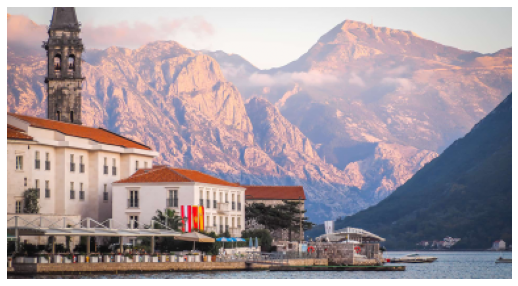

In [51]:
optimal_red =  get_optimal_shift(red_channel, green_channel, 15)
optimal_blue = get_optimal_shift(blue_channel, green_channel, 15)

print('Correction shift: R [y: %d, x: %d], B [y: %d, x: %d]'% (*optimal_red, *optimal_blue))

fixed_image = synth_image.copy()
fixed_image[..., 0] = apply_shift(red_channel, *optimal_red)
fixed_image[..., 2] = apply_shift(blue_channel, *optimal_blue)

plot_image(fixed_image, (10, 5))

### Problem 3: Aligning Prokudin-Gorskii triptychs

(0, -4)
(9, -5)


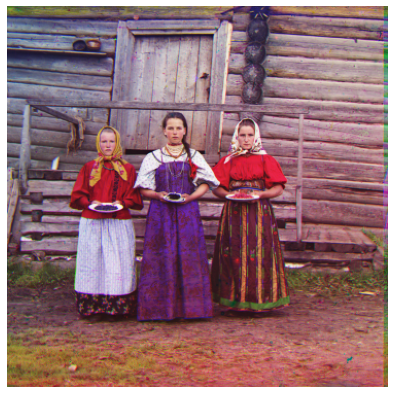

In [52]:

red = np.array(imread('images/prokudin-girls-red.ppm', as_gray=True) / 255.0)
blue = np.array(imread('images/prokudin-girls-blue.ppm', as_gray=True) / 255.0)
green = np.array(imread('images/prokudin-girls-green.ppm', as_gray=True) / 255.0)


optimal_red =  get_optimal_shift(red, green, 15)
optimal_blue = get_optimal_shift(blue, green, 15)

print(optimal_red)
print(optimal_blue)

red_fixed = apply_shift(red, *optimal_red)
blue_fixed = apply_shift(blue, *optimal_blue)

fixed_image = np.dstack((red_fixed, green, blue_fixed))
plot_image(fixed_image, (14, 7))

and the other one:

(3, 3)
(-2, -8)


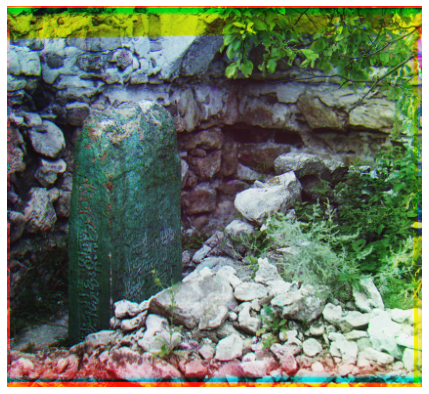

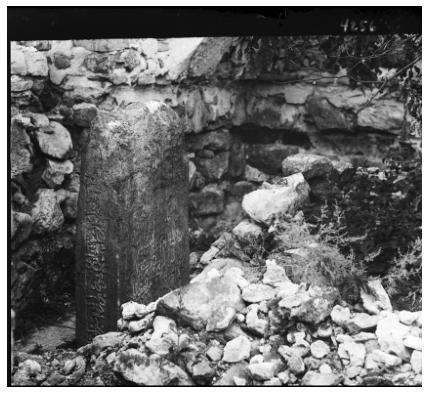

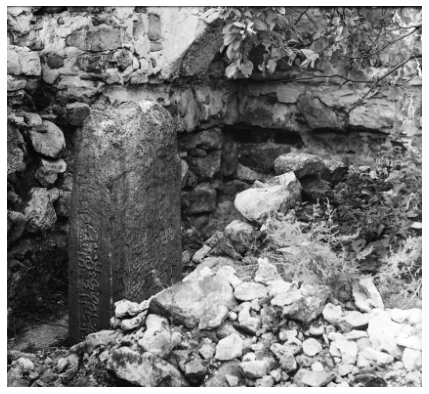

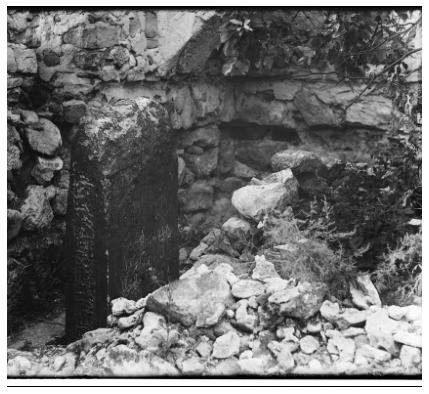

In [53]:
red = np.array(imread('images/prokudin-rock-red.ppm',as_gray=True) / 255.0)
blue = np.array(imread('images/prokudin-rock-blue.ppm',as_gray=True) / 255.0)
green = np.array(imread('images/prokudin-rock-green.ppm',as_gray=True) / 255.0)

optimal_red =  get_optimal_shift(red, green, 15)
optimal_blue = get_optimal_shift(blue, green, 15)

print(optimal_red)
print(optimal_blue)

red_fixed = apply_shift(red, *optimal_red)
blue_fixed = apply_shift(blue, *optimal_blue)

fixed_image = np.stack((red_fixed, green, blue_fixed), axis=-1)

plot_image(fixed_image, (14, 7))
plot_image(blue, (14, 7), "gray")
plot_image(green, (14, 7), "gray")
plot_image(red, (14, 7), "gray")

### Problem 3 Bonus 
Add here results on any additional triptychs

(-2, 2)
(9, 0)


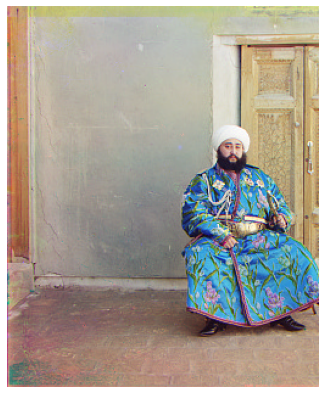

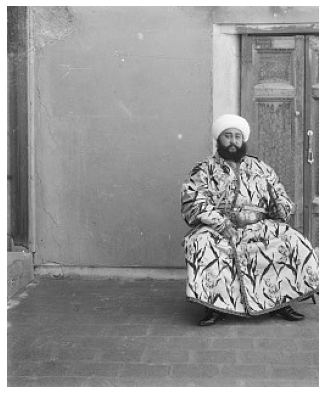

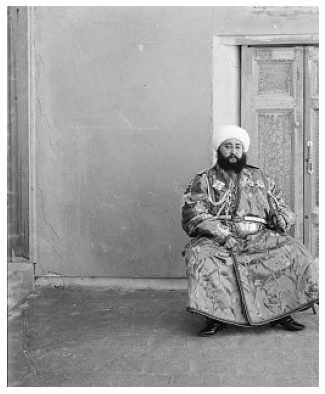

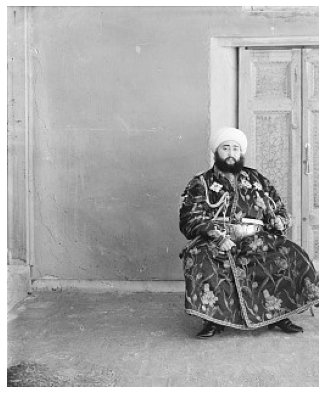

In [54]:
red = np.array(imread('images/trip_red.jpg',as_gray=True) / 255.0)[0:313,0:256]
blue = np.array(imread('images/trip_blue.jpg',as_gray=True) / 255.0)[0:313,0:256]
green = np.array(imread('images/trip_green.jpg',as_gray=True) / 255.0)[0:313,0:256]

optimal_red =  get_optimal_shift(red, green, 100)
optimal_blue = get_optimal_shift(blue, green, 100)

print(optimal_red)
print(optimal_blue)

red_fixed = apply_shift(red, *optimal_red)
blue_fixed = apply_shift(blue, *optimal_blue)

fixed_image = np.stack((red_fixed, green, blue_fixed), axis=-1)

plot_image(fixed_image, (14, 7))
plot_image(blue, (14, 7), "gray")
plot_image(green, (14, 7), "gray")
plot_image(red, (14, 7), "gray")

## Demosaicing

### load the mosaiced image
This is a single channel (graylevel) image, which as we know encodes color via a Bayer pattern

In [55]:
image_path = 'images/crayons.bmp'

def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

mosaic_img = read_image(image_path)

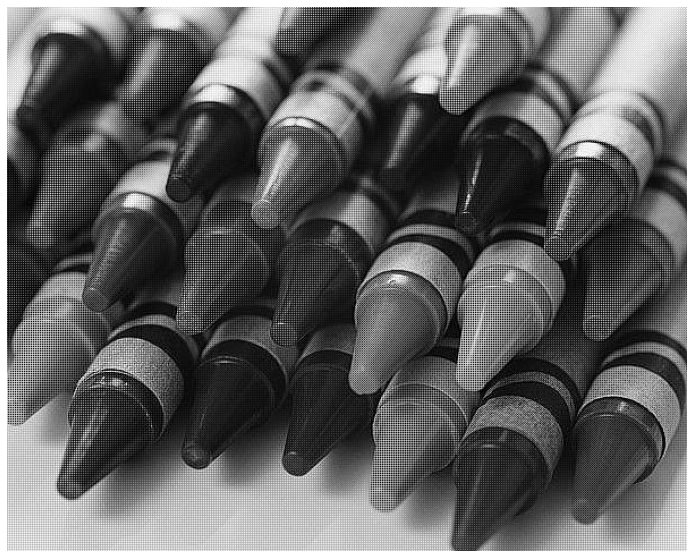

In [56]:
# Visualize the mosaic
plot_image(mosaic_img, (20, 10), 'gray')

In [57]:
mosaic_img.shape

(480, 600)

In [58]:
from scipy.ndimage.filters import convolve

In [59]:
# your code here; create the masks that correpond to each color pixel
R_m = np.zeros(mosaic_img.shape, dtype = 'uint8')
R_m.shape
R_m[::2,::2] = 1

G_m = np.zeros(mosaic_img.shape, dtype = 'uint8')
G_m.shape
G_m[1::2,::2] = 1
G_m[::2,1::2] = 1

B_m = np.zeros(mosaic_img.shape, dtype = 'uint8')
B_m.shape
B_m[1::2,1::2] = 1

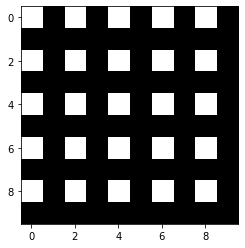

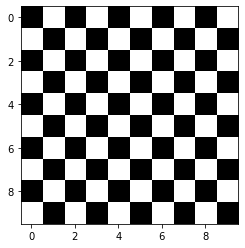

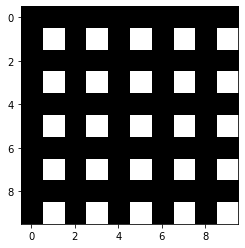

In [60]:
plt.imshow(R_m[:10,:10], cmap='gray')
plt.show()

plt.imshow(G_m[:10,:10], cmap='gray')
plt.show()

plt.imshow(B_m[:10,:10], cmap='gray')
plt.show()

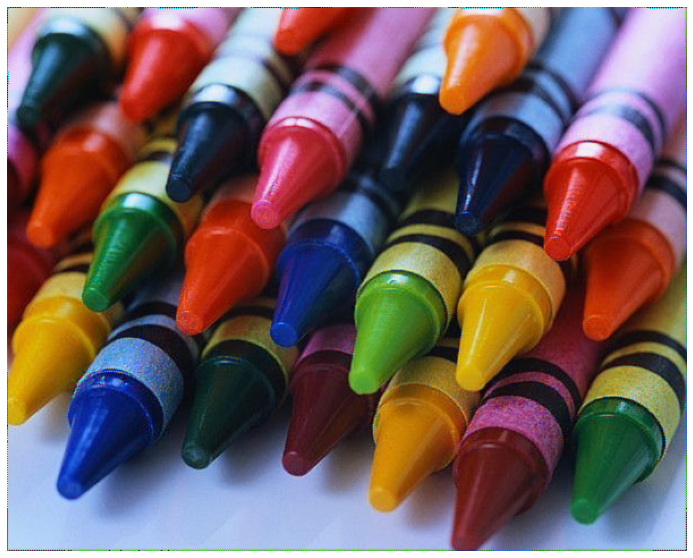

In [61]:
# Hint: apply filtering on masked layers. 
# Think about the right filter weights as they move to differen pixel locations. 
# The idea here is: if a pixel already has an assigned color, leave it unchanged. 
# Only fill in the color for the missing pixels. 

# Masking + Convolution by appropriate filter simplifies problem
# convolution kernels

# green filter
H_G = np.asarray(
    [[0, 1, 0],
     [1, 4, 1],
     [0, 1, 0]]) / 4
# red/blue filter
H_RB = np.asarray(
    [[1, 2, 1],
     [2, 4, 2],
     [1, 2, 1]]) / 4

# your code here
R = convolve(convolve(cv2.bitwise_and(mosaic_img, mosaic_img, mask = R_m), H_RB), H_G)
G = convolve(cv2.bitwise_and(mosaic_img, mosaic_img, mask = G_m), H_G)
B = convolve(convolve(cv2.bitwise_and(mosaic_img, mosaic_img, mask = B_m), H_RB), H_G)

rgb = np.stack((R,G,B), axis=-1)

plot_image(rgb, (20, 10))

To help us see the effect (and differences with the other method) zoom in on a small portion:

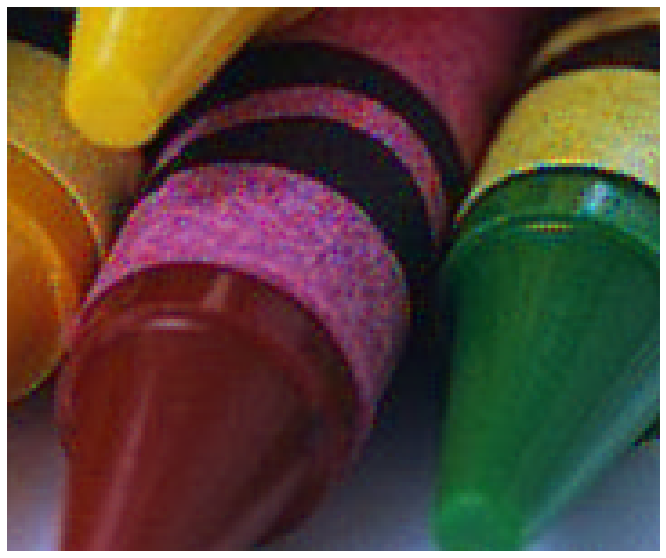

In [62]:
# focus on a small area
plot_image(rgb[300:450, 380:560, :], (20,10))

### Problem 6: Freeman's Method

In [63]:
from scipy.signal import medfilt2d

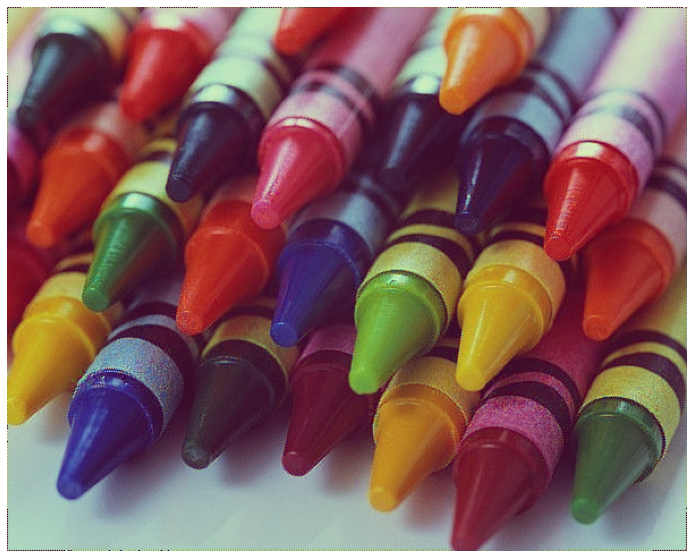

In [64]:
R, G, B = rgb[...,0], rgb[...,1], rgb[...,2]
Rscale = R.mean()
Gscale = G.mean()
Bscale = B.mean()

# your code here
RG = (R-Rscale) - (G-Gscale)
BG = (B-Bscale) - (G-Gscale)

RG2 = medfilt2d(RG, 3)
BG2 = medfilt2d(BG, 3)

R2 = RG2 + (G-Gscale)
B2 = BG2 + (G-Gscale)

R2 = R2 + Rscale
B2 = B2 + Rscale

# normalize the output
R2 = 255 * (R2 - R2.min()) / (R2.max() - R2.min())
B2 = 255 * (B2 - B2.min()) / (B2.max() - B2.min())

cleaned_rgb = np.dstack((R2, G, B2))

plot_image(cleaned_rgb.astype(np.uint8), (20, 10))

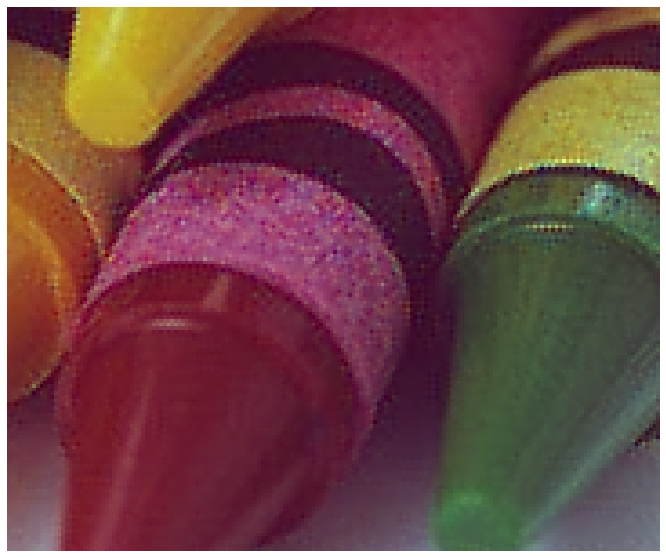

In [65]:
# focus on the same small area
plot_image(cleaned_rgb.astype(np.uint8)[300:450, 380:560, :], (20,10))

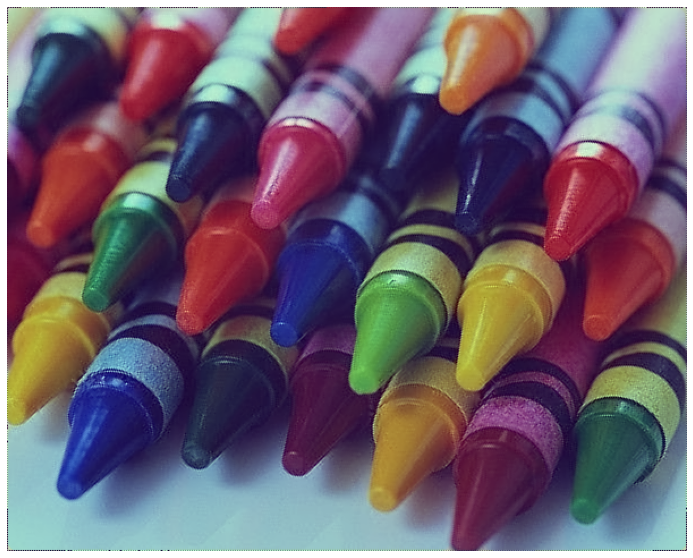

In [66]:
R, G, B = rgb[...,0], rgb[...,1], rgb[...,2]
Rscale = R.mean()
Gscale = G.mean()
Bscale = B.mean()

# your code here
RG = (R-Rscale) - (G-Gscale)
BG = (B-Bscale) - (G-Gscale)

RG2 = medfilt2d(RG, 11)
BG2 = medfilt2d(BG, 11)

R2 = RG2 + (G-Gscale)
B2 = BG2 + (G-Gscale)

R2 = R2 + Rscale
B2 = B2 + Rscale

# normalize the output
R2 = 255 * (R2 - R2.min()) / (R2.max() - R2.min())
B2 = 255 * (B2 - B2.min()) / (B2.max() - B2.min())

cleaned_rgb = np.dstack((R2, G, B2))

plot_image(cleaned_rgb.astype(np.uint8), (20, 10))

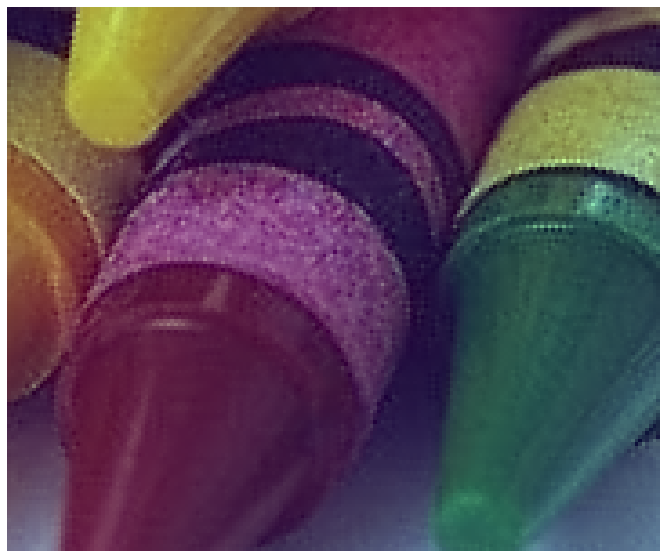

In [67]:
# focus on the same small area
plot_image(cleaned_rgb.astype(np.uint8)[300:450, 380:560, :], (20,10))

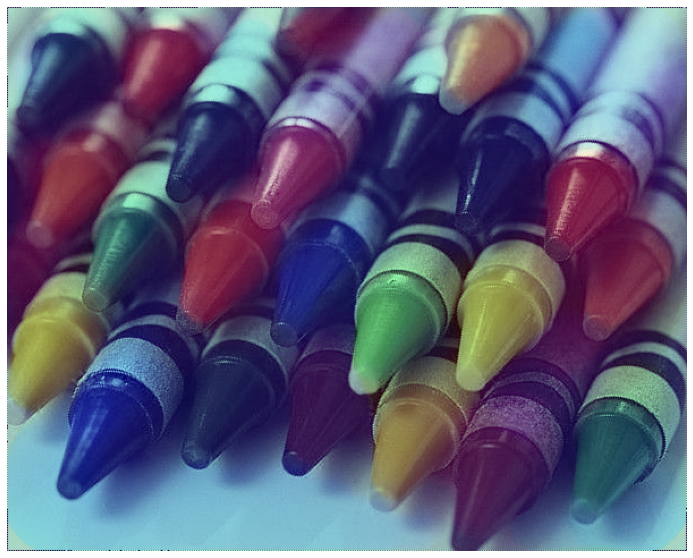

In [68]:
R, G, B = rgb[...,0], rgb[...,1], rgb[...,2]
Rscale = R.mean()
Gscale = G.mean()
Bscale = B.mean()

# your code here
RG = (R-Rscale) - (G-Gscale)
BG = (B-Bscale) - (G-Gscale)

RG2 = medfilt2d(RG, 51)
BG2 = medfilt2d(BG, 51)

R2 = RG2 + (G-Gscale)
B2 = BG2 + (G-Gscale)

R2 = R2 + Rscale
B2 = B2 + Rscale

# normalize the output
R2 = 255 * (R2 - R2.min()) / (R2.max() - R2.min())
B2 = 255 * (B2 - B2.min()) / (B2.max() - B2.min())

cleaned_rgb = np.dstack((R2, G, B2))

plot_image(cleaned_rgb.astype(np.uint8), (20, 10))

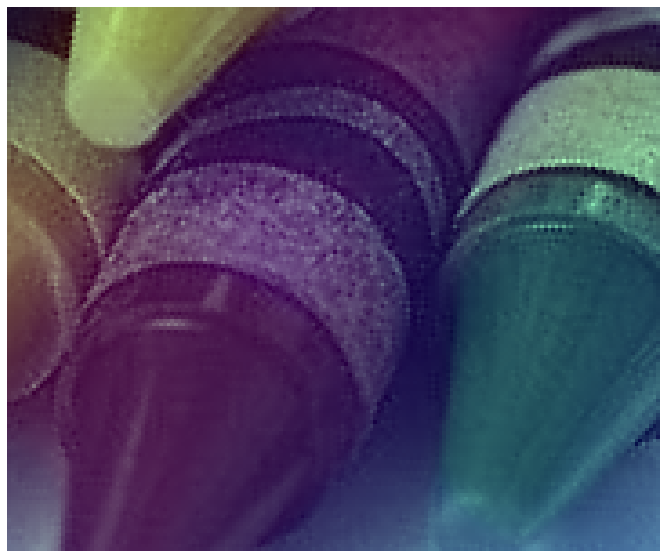

In [69]:
# focus on the same small area
plot_image(cleaned_rgb.astype(np.uint8)[300:450, 380:560, :], (20,10))

## Discussion
Add below your answers to qualitative questions about demosaicing artifacts

Images obtained by using a filter size of 3, 11 and 51 for the median filtering are displayed above. By visual inspection it seems that the filter size of 11 is doing a better job of reducing the splotches in the image. This makes sense as splotches originally obtained are quite large and may be a filter size of 3 may not be effective in normaizing them. It should also be noticed that a filter size too big(we take example of 51) will end up blurring the image.